Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolas Guarín-Zapata 2019. Este material es parte del curso Mecánica de los Medios Continuos en el programa de Ingeniería Civil de la Universidad EAFIT.

# Análisis de deformación.
(Medios Continuos)

### Introducción

En una gran cantidad de casos practicos es necesario determinar el campo de desplazamientos, tensiones y deformaciones unitarias por medio de simulaciones numéricas, por ejemplo con el método de los elementos finitos, por lo tanto es necesario saber interpretar este tipo de solcuiones. En este notebook estudiaremos el campo de deformaciones en un punto material a través de un modelo numérico.

In [49]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import meshio
import solidspy.preprocesor as msh
import solidspy.assemutil as ass
import solidspy.postprocesor as pos
import solidspy.solutil as sol
from matplotlib.tri import Triangulation, CubicTriInterpolator

In [50]:
def viewmesh(nodes , elements , view = False):
    #
    """Generates and displays a matplotlib.tri.Triangulation object created from a
       user defined finite element mesh given by nodes and elements.

    Parameters
    ----------
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY BCX BCY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    Returns
    -------
    tri : Triangulation
        An unstructured triangular grid consisting of npoints points
        and ntri triangles.

    """
    x = nodes[:, 1]
    y = nodes[:, 2]
    triangs = []
    for el in elements:
        if el[1]==2:
            triangs.append(el[[3, 4, 5]])
            triangs.append(el[[5, 6, 3]])
        if el[1]==9:
            triangs.append(el[[3, 6, 8]])
            triangs.append(el[[6, 7, 8]])
            triangs.append(el[[6, 4, 7]])
            triangs.append(el[[7, 5, 8]])
        if el[1]==3:
            triangs.append(el[3:])

    tri = Triangulation(x, y, np.array(triangs))
#
    if view:
        plt.figure()
        plt.gca().set_aspect('equal')
        plt.triplot(tri, lw=0.5, color='red')

    return tri

In [51]:
def readin():
    nodes = np.loadtxt('files/Rnodes.txt', ndmin=2)
    mats  = np.loadtxt('files/Rmater.txt', ndmin=2)
    elements = np.loadtxt('files/Reles.txt', ndmin=2, dtype=np.int)
    loads = np.loadtxt('files/Rloads.txt', ndmin=2)
    return nodes, mats, elements, loads

In [52]:
def viewmesh(nodes , elements , view = False):
    #
    """Generates and displays a matplotlib.tri.Triangulation object created from a
       user defined finite element mesh given by nodes and elements.

    Parameters
    ----------
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY BCX BCY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    Returns
    -------
    tri : Triangulation
        An unstructured triangular grid consisting of npoints points
        and ntri triangles.

    """
    x = nodes[:, 1]
    y = nodes[:, 2]
    triangs = []
    for el in elements:
        if el[1]==2:
            triangs.append(el[[3, 4, 5]])
            triangs.append(el[[5, 6, 3]])
        if el[1]==9:
            triangs.append(el[[3, 6, 8]])
            triangs.append(el[[6, 7, 8]])
            triangs.append(el[[6, 4, 7]])
            triangs.append(el[[7, 5, 8]])
        if el[1]==3:
            triangs.append(el[3:])

    tri = Triangulation(x, y, np.array(triangs))
#
    if view:
        plt.figure(0)
        plt.gca().set_aspect('equal')
        plt.triplot(tri, lw=0.5, color='red')

    return tri

In [53]:
def deformed_config(nodes , elements , scale_fact):
    nodes_def = nodes[:, 1:3] + scale_fact*UC
    plt.figure()
    plt.triplot(nodes[:, 1], nodes[:, 2], elements[:, -3:], color="gray", alpha=0.5)
    plt.triplot(nodes_def[:, 0], nodes_def[:, 1], elements[:, -3:])

In [54]:
mesh = meshio.read("files/rve.msh")
points     = mesh.points
point_data = mesh.point_data
cells      = mesh.cells
cell_data  = mesh.cell_data

nodes_array    = msh.node_writer(points, point_data)
nf , els_array = msh.ele_writer(cells, cell_data, "triangle", 100, 3, 0, 0)
nodes_array    = msh.boundary_conditions(cells, cell_data, 100, nodes_array, 0 , -1)
np.savetxt("files/Reles.txt", els_array, fmt="%d")
np.savetxt("files/Rnodes.txt", nodes_array, fmt=("%d", "%.4f", "%.4f", "%d", "%d"))

## Análisis.

Suponga que el punto material es de dimensiones $1.0m \times 1.0m$ y que aplicaremos tensiones $\sigma$ y $\tau$ sobre la frontera superior. El medio tiene modulo de elasticidad $E = 50.0 GPa$ y relación de Poisson $\nu = 0.3$.

<IPython.core.display.Javascript object>


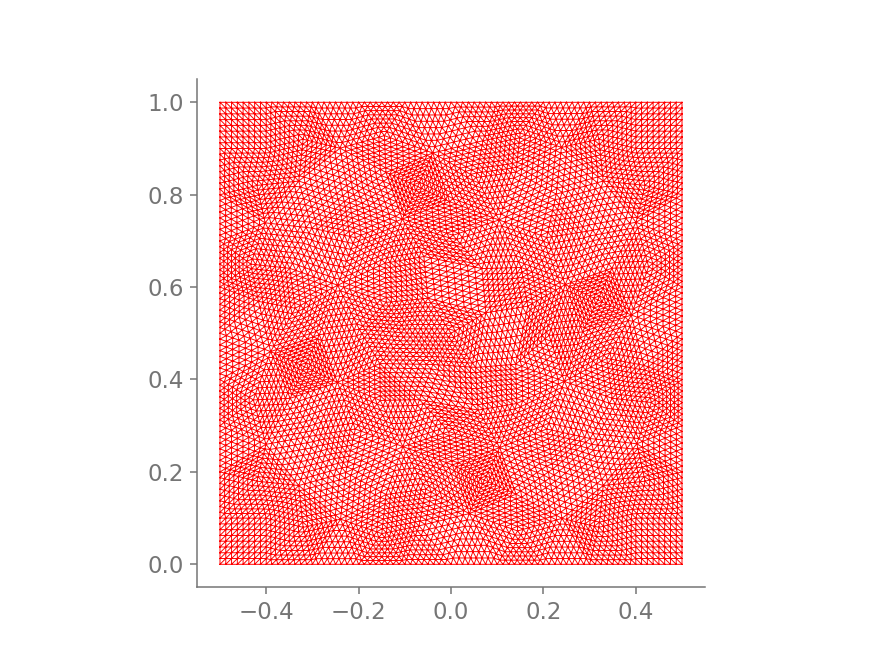

In [55]:
nodes, mats, elements, loads = readin()
trii = viewmesh(nodes , elements , True)

### Análisis

Apliquemos una carga total correspondiente a $F_T = \sigma \times l$. En este caso hagamos $\sigma = 1.0 MPa$.

**¿Para esta carga y propiedades de material cual es el valor esperado de las deformaciones y los desplzamientos en las direcciones $x$ y $y$?**

In [56]:
cargas = msh.loading(cells, cell_data, 200 , 0.0 , -1.0e6)
np.savetxt("files/Rloads.txt", cargas, fmt=("%d", "%.3g", "%.3g"))

In [57]:

DME, IBC, neq = ass.DME(nodes, elements)
mat_rigidez = ass.assembler(elements, mats, nodes, neq, DME)
force_vec = ass.loadasem(loads, IBC, neq)
UG = sol.static_sol(mat_rigidez, force_vec)
UC = pos.complete_disp(IBC, nodes, UG)
#print(UC)

<IPython.core.display.Javascript object>


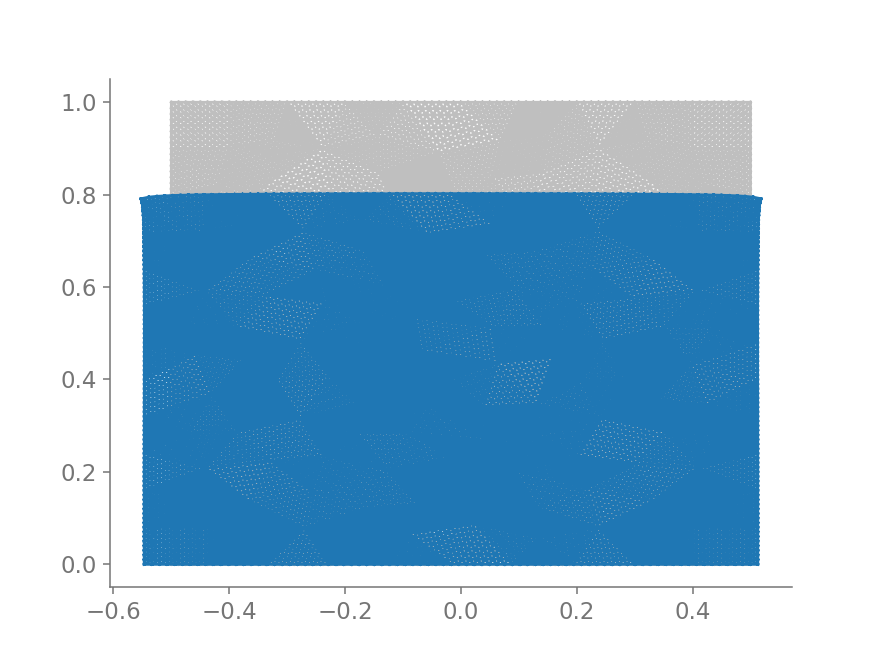

In [58]:
deformed_config(nodes , elements , scale_fact = 1.0e4)

**Antes de ver los resultados de desplazamientos y deformaciones trate de anticipar como deben aparecer los resultados. Con su equipo de trabajo trate de hacer los contornos a mano para cada una de las componentes del tensor de deformaciones unitarias.**

[[ 5.97868006e-06 -1.99277996e-05  5.03236313e-10]
 [ 5.97867909e-06 -1.99277962e-05 -5.03234214e-10]
 [ 7.93186629e-06 -2.78306294e-05 -7.62783339e-06]
 ...
 [ 5.83299521e-06 -1.97745550e-05  4.61130335e-08]
 [ 5.83405079e-06 -1.97764232e-05  6.11907543e-08]
 [ 5.83596094e-06 -1.97797241e-05  5.13111167e-08]]


<IPython.core.display.Javascript object>


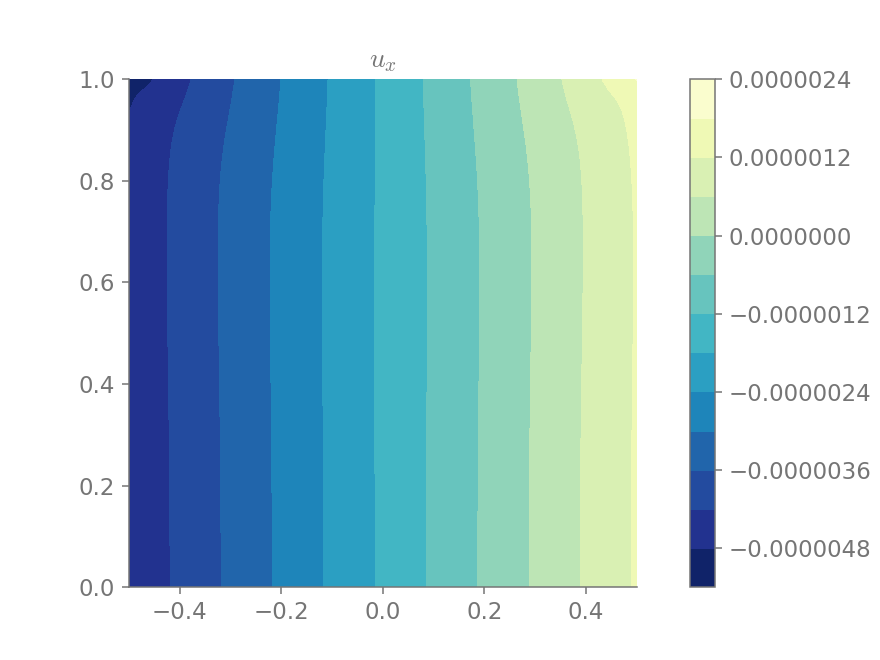

<IPython.core.display.Javascript object>


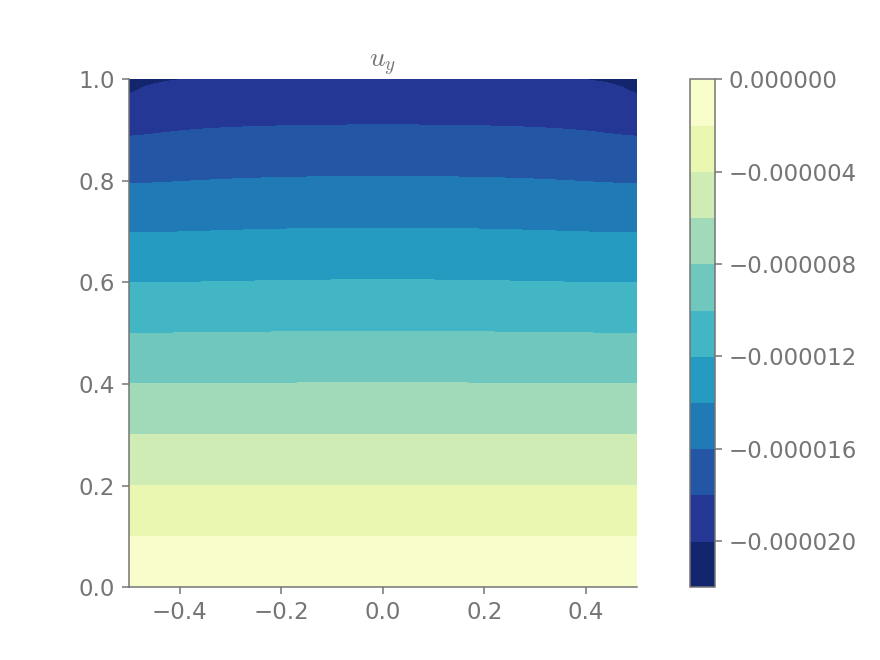

<IPython.core.display.Javascript object>


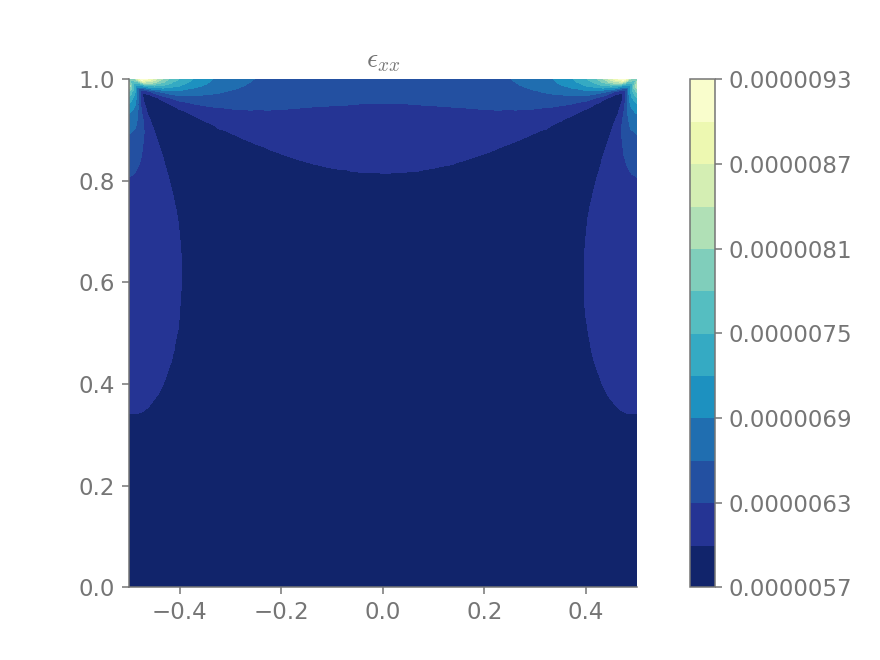

<IPython.core.display.Javascript object>


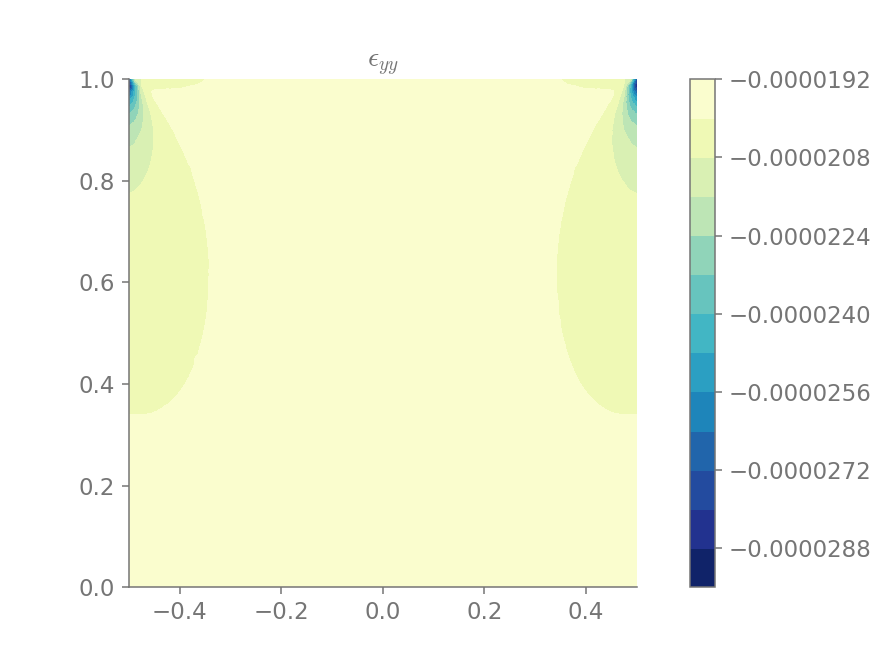

<IPython.core.display.Javascript object>


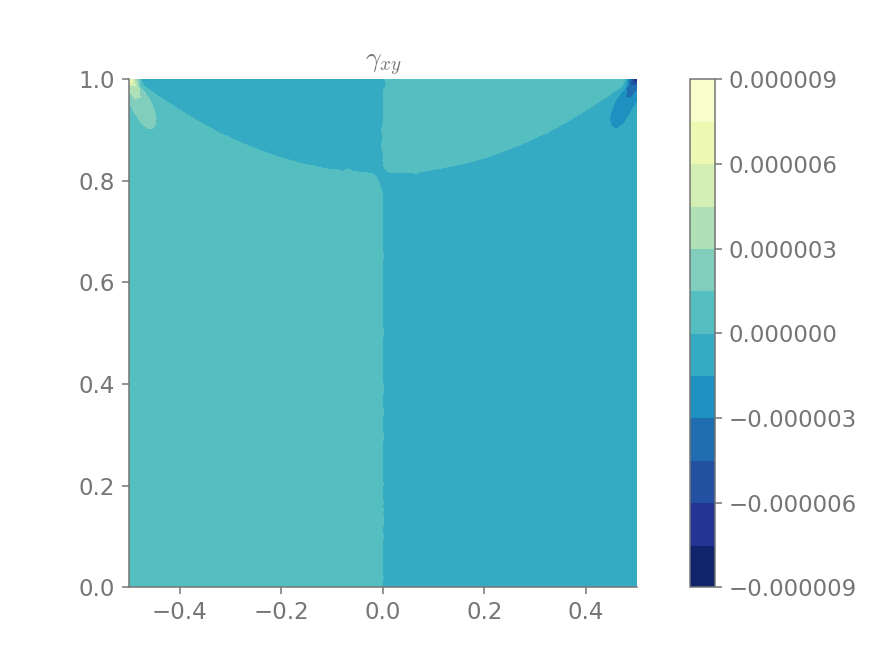

In [59]:
E_nodes, S_nodes = pos.strain_nodes(nodes, elements, mats, UC)
print(E_nodes)
pos.fields_plot(elements, nodes, UC, E_nodes=E_nodes)

## Tracción y cortante

Repita el análisis si la carga es ahora aplicada en tracción y cortante respectivamente. De manera similar trate de aplicar cargas en 2 direcciones perpendiculares y repita el análisis.

### Referencias

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()